#
#
DEEP LEARNING EJECTA PATTERN ANALYSIS

In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rasterio
import rioxarray
from shapely import Point, Polygon, MultiPolygon, LineString
import matplotlib.pyplot as plt


from pyproj import CRS, Transformer

import time
import gc
import glob

from sklearn.metrics import confusion_matrix

import scipy.ndimage as sni

from az_processing import *
from pos_processing import *
from planet_constants import Planet_Basemap, Planet_Properties, Planet_CRS


/home/mlissoni/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


A function to compute the blanket radius and do some analysis of the crater patterns

The function is called twice, once on the individual pattern and once on the "cleaned" pattern, where overlaps with other patterns have been removed.

In [3]:
def craterAnalysis(mask, # Cylindrical or azimuthal crater ejecta pattern
                   center_coords, # Coordinates of the crater center
                   crater_radius, # Crater radius
                   az_mosaic, # Enhanced Color mosaic, reprojected
                   crater_geoseries = None, # gpd.GeoSeries containing the crater geometry
                   feat_min_size = 100, # Pixel clusters smaller than this are eliminated in denoising 
                   all_distances_whole = None, # Distance grid (to avoid computing it twice)
                   blanket_radius = None, # Blanket radius (computed if not set)
                   blanket_step = 4, # Pixel step to find the blanket
                   blanket_start = 4, # Distance, in crater radii, where the blanket search should start
                   blanket_thres = 0.5, # Threshold for blanket radius, in terms of ejecta coverage of circumference around crater
                   az_resolution = Planet_Basemap.BASEMAP_RESOLUTION, # Resolution of the mask
                   num_threads = 1, # Number of subprocesses
                   plot = False, # If True, the crater ejecta pattern is plotted
                   already_az = False, # Set True if `mask` is already azimuthal
                   return_az_mask = False # Set True to get the azimuthal mask
                  ):

    crater_radius_px = crater_radius/az_resolution

    zero_analysis_dict = {'radius': crater_radius_px,
                     'blanket_radius': 0,
                     'max_distance': 0,
                     'area': 0,
                     'blanket_area': 0,
                     'rays_area': 0,
                     'bar_x': 0,
                     'bar_y': 0,
                     'ray_bar_x': 0,
                     'ray_bar_y': 0,
                     'blanket_PC2': 0,
                     'blanket_PC1': 0,
                     'blanket_4301000': 0,
                     'ray_PC2': 0,
                     'ray_PC1': 0,
                     'ray_4301000': 0}

    for i in range(0,8):
        zero_analysis_dict['ray_sect'+str(i)] = 0

    if(np.sum(mask)==0):
        print("Mask empty")
        if(return_az_mask):
            az_mask = emptyAz(center_coords)
            return zero_analysis_dict, az_mask
        else:
            return zero_analysis_dict

    if(already_az):
        az_mask = mask.copy()
    else: # Reproject mask to azimuthal
        az_mask = reprojectAz(mask, center_coords, az_resolution = az_resolution, num_threads = num_threads)

        if(np.sum(az_mask)==0):
            if(return_az_mask):
                return zero_analysis_dict, az_mask
            else:
                return zero_analysis_dict            

    # Shrink mask and mosaic to only the area containing the ejecta
    
    half_size = int(az_mask.shape[1]/2)

    one_indices_x = np.flatnonzero(np.any(az_mask[0,:,:], axis=0))
    one_indices_y = np.flatnonzero(np.any(az_mask[0,:,:], axis=1))
    bound_min_x = np.amin(one_indices_x)
    bound_max_x = np.amax(one_indices_x)+1
    bound_min_y = np.amin(one_indices_y)
    bound_max_y = np.amax(one_indices_y)+1 

    half_size_new = np.amax(np.abs(np.array([bound_min_x, bound_max_x, bound_min_y, bound_max_y])-half_size))

    # Even smaller size to compute the crater rim mask (to exclude the crater itself from the analysis)
    
    tiny_half_size = min(int(crater_radius_px*3), half_size_new)
    tiny_mask = az_mask[0,half_size-tiny_half_size:half_size+tiny_half_size, half_size-tiny_half_size:half_size+tiny_half_size].copy()
    tiny_transform = tiny_mask.rio.transform(recalc=True)
    del tiny_mask
    gc.collect()
    
    az_mask = az_mask[:,half_size-half_size_new:half_size+half_size_new, half_size-half_size_new:half_size+half_size_new]
    if(return_az_mask):
        az_mask0 = az_mask.copy()
        
    az_mask = az_mask.values[0,:,:]
    
    small_mosaic = az_mosaic[:,half_size-half_size_new:half_size+half_size_new, half_size-half_size_new:half_size+half_size_new].values

    # Compute the distance of every pixel in the ejecta mask from the crater center
    
    if(all_distances_whole is not None):
        all_distances = all_distances_whole[half_size-half_size_new:half_size+half_size_new, half_size-half_size_new:half_size+half_size_new].flatten()
    else:
        xgrid, ygrid = np.meshgrid(np.arange(-half_size_new, half_size_new) + 0.5, np.flip(np.arange(-half_size_new, half_size_new)+ 0.5))
        all_distances = np.sqrt(np.square(xgrid)+np.square(ygrid))
        
    half_size = half_size_new

    # Denoise the mask, remove small clusters of pixels
    
    az_mask = denoiseMask(az_mask, feat_min_size = feat_min_size)

    if(np.sum(az_mask)==0):
        print("Mask empty after denoising")
        if(return_az_mask):
            return zero_analysis_dict, az_mask0
        else:
            return zero_analysis_dict

    nonzero_indices_y, nonzero_indices_x = np.nonzero(az_mask)

    # Remove crater itself from the mask
    
    if crater_geoseries is not None:
        az_crs = getAzCRS(*center_coords)
        crater_geometry = crater_geoseries.to_crs(az_crs).geometry.iloc[0]
        crater_mask0 = rasterio.features.geometry_mask([crater_geometry], 
                                                      (tiny_half_size*2, tiny_half_size*2), 
                                                      tiny_transform,
                                                      all_touched = False,
                                                      invert=True)
        crater_mask = az_mask.copy()
        crater_mask[:,:] = 0
        crater_mask[half_size-tiny_half_size : half_size+tiny_half_size,half_size-tiny_half_size : half_size+tiny_half_size] = crater_mask0[:,:]
        crater_indices = np.flatnonzero(crater_mask[nonzero_indices_y, nonzero_indices_x])

        az_mask = (crater_mask*(-1)+1)*az_mask

    # Compute polar coordinates (distances, angles) of ejecta pixels
    
    nonzero_coords_x = nonzero_indices_x - half_size + 0.5
    nonzero_coords_y = half_size - nonzero_indices_y - 0.5
    
    distances = np.sqrt(np.square(nonzero_coords_x) + np.square(nonzero_coords_y))

    angles = np.arctan2(nonzero_coords_x*(-1), nonzero_coords_y)/np.pi*180

    # Find blanket radius
    
    if(blanket_radius is None):
    
        perim_ratio = 1
        blanket_radius = int(blanket_start*crater_radius_px) - blanket_step
        
        while(perim_ratio > blanket_thres and blanket_radius < half_size):
            blanket_radius += blanket_step
            perim_points = np.sum((all_distances >= blanket_radius - blanket_step/2) & (all_distances < blanket_radius + blanket_step/2))
            perim_ejecta = np.sum((distances >= blanket_radius - blanket_step/2) & (distances < blanket_radius + blanket_step/2))
            perim_ratio = perim_ejecta*1.0/perim_points if perim_points > 0 else 0
            
        if(blanket_radius==int(blanket_start*crater_radius_px)):
            while(perim_ratio <= blanket_thres and blanket_radius>blanket_step):
                blanket_radius -= blanket_step
                perim_points = np.sum((all_distances >= blanket_radius - blanket_step/2) & (all_distances < blanket_radius + blanket_step/2))
                perim_ejecta = np.sum((distances >= blanket_radius - blanket_step/2) & (distances < blanket_radius + blanket_step/2))
                perim_ratio = perim_ejecta*1.0/perim_points if perim_points>0 else 0 

            blanket_radius = 0 if blanket_radius <= blanket_step or perim_points==0 else blanket_radius

    if crater_geoseries is not None:
        distances = np.delete(distances,crater_indices)
        angles = np.delete(angles,crater_indices)
        nonzero_coords_x = np.delete(nonzero_coords_x,crater_indices)
        nonzero_coords_y = np.delete(nonzero_coords_y,crater_indices)
        nonzero_indices_x = np.delete(nonzero_indices_x, crater_indices)
        nonzero_indices_y = np.delete(nonzero_indices_y, crater_indices)
    
    blanket_indices = np.flatnonzero(distances <= blanket_radius)
    ray_indices = np.flatnonzero(distances > blanket_radius)
    
    analysis_dict = zero_analysis_dict

    analysis_dict['blanket_radius'] = blanket_radius # Blanket radius
    analysis_dict['area'] = len(nonzero_indices_y) # Number of ejecta pixels
    analysis_dict['blanket_area'] = len(blanket_indices) # Number of ejecta pixels in the blanket
    analysis_dict['rays_area'] = len(ray_indices) # Number of ejecta pixels outside the blanket

    if len(distances) == 0:
        if(return_az_mask):
            return analysis_dict, az_mask0
        else:
            return analysis_dict

    # Distance quantiles
    
    analysis_dict['max_distance'] = np.amax(distances)
    analysis_dict['distance_99'] = np.quantile(distances, 0.99)
    analysis_dict['distance_95'] = np.quantile(distances, 0.95)
    analysis_dict['distance_90'] = np.quantile(distances, 0.9) 
    analysis_dict['distance_75'] = np.quantile(distances, 0.75)
    analysis_dict['distance_50'] = np.quantile(distances, 0.5) 
    analysis_dict['distance_25'] = np.quantile(distances, 0.25)

    # Baricenter of ejecta pattern
    
    baricenter = np.array([np.mean(nonzero_coords_x), np.mean(nonzero_coords_y)])

    analysis_dict['bar_x'] = baricenter[0]
    analysis_dict['bar_y'] = baricenter[1]

    ejecta_sectors = np.digitize(angles,np.arange(-180,180,45), right=False) - 1   
    sectors, sector_counts = np.unique(ejecta_sectors, return_counts=True)
    ejecta_per_sector = np.zeros(8, dtype=int)
    ejecta_per_sector[sectors] = sector_counts

    # Pattern divided in 8 sectors
    
    for sector in range(0,8):
        area_sector = ejecta_per_sector[sector]  
        analysis_dict['area_sect'+str(sector)] = area_sector  # Number of ejecta pixels in sector

        # Maximum distance in sector
        analysis_dict['distmax_sect'+str(sector)] = np.amax(distances[ejecta_sectors==sector]) if area_sector > 0 else 0

    # Enhanced Color mosaic mean value in blanket        
    if(len(blanket_indices)>0):
        blanket_PC2, blanket_PC1, blanket_4301000 = np.mean(small_mosaic[:, nonzero_indices_y[blanket_indices], nonzero_indices_x[blanket_indices]], axis=1)
        analysis_dict['blanket_PC2'] = blanket_PC2
        analysis_dict['blanket_PC1'] = blanket_PC1
        analysis_dict['blanket_4301000'] = blanket_4301000

    if(len(ray_indices)>0):
        baricenter_rays = np.array([np.mean(nonzero_coords_x[ray_indices]), np.mean(nonzero_coords_y[ray_indices])])

        ray_PC2, ray_PC1, ray_4301000 = np.mean(small_mosaic[:, nonzero_indices_y[ray_indices], nonzero_indices_x[ray_indices]], axis=1)

        sectors, sector_counts = np.unique(ejecta_sectors[ray_indices], return_counts=True)
        rays_per_sector = np.zeros(8, dtype=int)
        rays_per_sector[sectors] = sector_counts

        # Rays baricenter
        analysis_dict['ray_bar_x'] = baricenter_rays[0]
        analysis_dict['ray_bar_y'] = baricenter_rays[1]

        # Enhanced Color mosaic mean value in rays 
        analysis_dict['ray_PC2'] = ray_PC2
        analysis_dict['ray_PC1'] = ray_PC1
        analysis_dict['ray_4301000'] = ray_4301000

        # Number of ray ejecta pixels in sector
        for sector in range(0,8): 
            analysis_dict['ray_sect'+str(sector)] = rays_per_sector[sector]
    else:
        rays_per_sector = np.zeros(8, dtype=int)

    # Plot pattern
    if(plot):
        circle_angles = np.arange(0,361,5)/180*np.pi
        circle_coords = np.hstack([np.cos(circle_angles)[:,np.newaxis], np.sin(circle_angles)[:,np.newaxis]])*blanket_radius+half_size
        
        fig, ax = plt.subplots(1,1, figsize = (10,10))#, width_ratios=[2,1])
        ax.imshow(np.transpose(small_mosaic,(1,2,0)), zorder=0)
        ax.imshow(az_mask*1.0, alpha=0.5, cmap='binary_r', zorder=1)
        ax.plot(circle_coords[:,0], circle_coords[:,1], 'r-', linewidth = 5, zorder=2)
        ax.set_axis_off()
        ax.margins(x=0, y=0, tight=True)
        fig.tight_layout(pad=0)

        plt.show()
        print('Mosaic half size: ', half_size)
    
    if(return_az_mask):
        return analysis_dict, az_mask0
    else:
        return analysis_dict

Analysis parameters

In [4]:
# Analysis parameters

blanket_step = 4
blanket_thres = 0.5
blanket_start = 4
feat_min_size = 100
num_threads = 12

Call the craterAnalysis function

In [10]:

generate_az = False # If True, the code loops through all the craters, generates all the azimuthal ejecta patterns
                    # and redoes the analysis from scratch

plot = False # Plot the crater pattern (automatically False if `generate_az` is True)

# Craters to plot... ignore if `generate_az` is True
iter_crater_FIDs = [12, 13, 8]#[3, 8, 12, 13, 17, 26, 34, 57, 90] #[45, 90, 112, 135] #[29, 45, 57, 134]#[45, 76, 80, 91, 113] #[53, 96, 110, 126]# None

# Threshold to exclude craters where more than this fraction of the blanket overlaps with ejecta from another crater
invalid_blanket_ratio_thres = 0.2

ejc_data_root="__EJMAP_ROOT_DIR__/data/ejc_data/"
map_dir = "__EJMAP_ROOT_DIR__/results/output_masks/ejc-version-200_conn-version-32_test-set-61_x20"
mosaic_dir = "__EJMAP_ROOT_DIR__/data/mosaics/"

###############################################3

if(generate_az):
    plot = False
    iter_crater_FIDs = None

fresh_craters_gdf = gpd.read_file(os.path.join(ejc_data_root, 'fresh_craters.shp')).set_index('crat_FID')
crater_FIDs = np.sort(fresh_craters_gdf.index.values)
iter_crater_FIDs = crater_FIDs if iter_crater_FIDs is None else iter_crater_FIDs

empty_mask, _ = emptyPosMask()
x_left_whole, _, _, y_top_whole = empty_mask.rio.bounds()
top_left_whole = (x_left_whole, y_top_whole)

# Create a raster to filter out zones where the ejecta of multiple craters overlap

overlap_mask = empty_mask.copy().values[0,:,:]

for crat_FID in crater_FIDs:

    crat_mask = rioxarray.open_rasterio(os.path.join(map_dir, 'cylindrical_mask_crater_'+str(crat_FID)+'.tif')).astype(np.uint8)

    overlap_mask = fillCyl(crat_mask, whole_raster = overlap_mask, top_left_whole = top_left_whole, flat=True)

overlap_mask[np.nonzero(overlap_mask > 1)] = 0
overlap_mask = overlap_mask[np.newaxis,:,:]

az_resolution = Planet_Basemap.BASEMAP_RESOLUTION
az_half_size = int(Planet_Properties.RADIUS*np.pi/Planet_Basemap.BASEMAP_RESOLUTION)

xgrid, ygrid = np.meshgrid(np.arange(-az_half_size, az_half_size) + 0.5, np.flip(np.arange(-az_half_size, az_half_size)+ 0.5))
all_distances_whole = np.sqrt(np.square(xgrid)+np.square(ygrid))
del xgrid
del ygrid
gc.collect()

if(generate_az): # Create new analysis_overlaps and analysis_clean dataframes to do the analysis from scratch
    analysis_overlaps = pd.DataFrame(index = crater_FIDs, columns = ['radius',
                                                                     'invalid',
                                                                     'blanket_radius',
                                                                     'area',
                                                                     'blanket_area',
                                                                     'rays_area',
                                                                     'bar_x',
                                                                     'bar_y',
                                                                     'ray_bar_x',
                                                                     'ray_bar_y',
                                                                     'blanket_PC2',
                                                                     'blanket_PC1',
                                                                     'blanket_4301000',
                                                                     'ray_PC2',
                                                                     'ray_PC1',
                                                                     'ray_4301000'] + ['ray_sect'+str(sector) for sector in range(0,8)])
    
    analysis_clean = analysis_overlaps.copy()
    
else: # Or open the existing ones if the only purpose is to plot the patterns
    analysis_overlaps = pd.read_csv(os.path.join(map_dir, 'analysis_overlaps.csv'), index_col='crat_FID')
    analysis_clean = pd.read_csv(os.path.join(map_dir, 'analysis_clean.csv'), index_col='crat_FID')

time_start = time.time()

# Loop over the craters (either those given in input or all of them, if the analysis is to be redone from scratch)

for crat_FID in iter_crater_FIDs:

    mask = rioxarray.open_rasterio(os.path.join(map_dir, 'cylindrical_mask_crater_'+str(crat_FID)+'.tif')).astype(np.uint8)
    
    mask = fillCyl(mask, whole_raster = empty_mask.copy(), top_left_whole = top_left_whole, flat=False)

    mask_clean = mask*overlap_mask # Ejecta mask without overlaps

    crater_radius = fresh_craters_gdf.loc[crat_FID, 'radius']
    crater_radius_px = crater_radius/az_resolution

    center_lon = fresh_craters_gdf.loc[crat_FID, 'center_lon']
    center_lat = fresh_craters_gdf.loc[crat_FID, 'center_lat']

    az_mosaic = rioxarray.open_rasterio(os.path.join(mosaic_dir, 'azimuthal_mosaic_crater_'+str(crat_FID)+'.tif')).astype(np.uint8)

    crater_geoseries = fresh_craters_gdf.geometry.loc[[crat_FID]]
    
    if(generate_az): # Analyse the pattern with overlaps included and generate azimuthal ejecta mask
        analysis_dict, az_mask = craterAnalysis(mask,
                                       (center_lon, center_lat), 
                                       crater_radius, 
                                       az_mosaic,
                                       crater_geoseries = crater_geoseries,
                                       feat_min_size = feat_min_size, 
                                       all_distances_whole = all_distances_whole, 
                                       blanket_radius = None, 
                                       blanket_step = blanket_step, 
                                       blanket_start = blanket_start,
                                       blanket_thres = blanket_thres, 
                                       plot = plot,
                                       already_az = False,
                                       return_az_mask = True,
                                       num_threads = num_threads)

        az_mask.rio.to_raster(os.path.join(map_dir, 'azimuthal_mask_crater_'+str(crat_FID)+'.tif')) 
                                                
    else:
        analysis_dict = craterAnalysis(mask,
                                       (center_lon, center_lat), 
                                       crater_radius, 
                                       az_mosaic,
                                       crater_geoseries = crater_geoseries,
                                       feat_min_size = feat_min_size, 
                                       all_distances_whole = all_distances_whole, 
                                       blanket_radius = None, 
                                       blanket_step = blanket_step, 
                                       blanket_start = blanket_start,
                                       blanket_thres = blanket_thres, 
                                       plot = plot,
                                       already_az = False,
                                       return_az_mask = False,
                                       num_threads = num_threads)
        
        az_mask = rioxarray.open_rasterio(os.path.join(map_dir, 'azimuthal_mask_crater_'+str(crat_FID)+'.tif')).astype(np.uint8)
    
    az_mask = fillAz(az_mask, (center_lon, center_lat))
    
    blanket_radius = analysis_dict['blanket_radius'] # The blanket radius is computed from the denoised mask that includes the overlaps

    # Analysis of the clean mask that excludes the overlaps
    analysis_clean_dict, mask_clean_az = craterAnalysis(mask_clean, 
                                   (center_lon, center_lat), 
                                   crater_radius, 
                                   az_mosaic,
                                   crater_geoseries = crater_geoseries, 
                                   feat_min_size = feat_min_size, 
                                   all_distances_whole = all_distances_whole, 
                                   blanket_radius = blanket_radius, 
                                   plot = plot,
                                   num_threads = num_threads,
                                   return_az_mask = True) 
    
    invalid = analysis_dict['blanket_area']==0 or analysis_clean_dict['blanket_area']/analysis_dict['blanket_area'] < 1 - invalid_blanket_ratio_thres

    analysis_dict['invalid'] = invalid
    analysis_clean_dict['invalid'] = invalid

    analysis_overlaps.loc[crat_FID, list(analysis_dict.keys())] = list(analysis_dict.values())
    analysis_clean.loc[crat_FID, list(analysis_clean_dict.keys())] = list(analysis_clean_dict.values())

    del az_mosaic
    del az_mask
    gc.collect()
    
    print(crat_FID, invalid, time.time()-time_start)

        
    time_start = time.time()


if(generate_az): # If the analysis has been done from scratch, save the results
    analysis_overlaps.to_csv(os.path.join(map_dir, 'analysis_overlaps.csv'), index=True, index_label='crat_FID')
    analysis_clean.to_csv(os.path.join(map_dir, 'analysis_clean.csv'), index=True, index_label='crat_FID')

161 False 14.852938175201416
162 False 15.373021125793457
Mask empty
163 True 10.48394250869751
164 True 16.864118576049805
165 False 17.1374032497406
166 False 17.40301775932312
167 False 17.478564977645874
168 False 17.57905602455139
169 False 18.951061487197876
170 False 18.34044623374939
171 True 17.635468006134033
172 False 18.292370796203613
Mask empty
173 True 11.73175835609436
174 False 16.948805809020996
175 False 16.978348970413208
176 True 17.00820016860962
Mask empty after denoising
177 True 16.59249520301819
178 True 16.760109901428223
179 True 16.050209522247314
180 True 16.664774417877197
Mask empty after denoising
181 True 16.300448179244995
182 True 16.755043745040894
183 False 16.13466477394104
184 False 16.54574751853943
185 False 16.737898111343384
186 False 16.92804479598999
187 False 16.357787132263184
Mask empty after denoising
188 True 16.043853521347046
189 False 16.099735975265503
Mask empty
190 True 11.27665662765503
Mask empty
191 True 10.815670490264893
192

Perform the same analysis with the MAN craters

In [ ]:
ejc_data_root="__EJMAP_ROOT_DIR__/data/ejc_data/"
mosaic_dir = "__EJMAP_ROOT_DIR__/data/mosaics/"
cyl_data_root = "__EJMAP_ROOT_DIR__/data/cyl_data/"
hm_dir = "__EJMAP_ROOT_DIR__/data/man_data/"

name_FID_dict = {'Amaral': 10,
                 'Basho': 8,
                 'Debussy': 12,
                 'Degas': 13,
                 'Enwonwu': 22,
                 'HanKan': 3,
                 'Hokusai': 0,
                 'Kuiper': 17,
                 'Waters': 71,
                 'XiaoZhao': 34}
crater_names = list(name_FID_dict.keys())

az_resolution = Planet_Basemap.BASEMAP_RESOLUTION
az_half_size = int(Planet_Properties.RADIUS*np.pi/Planet_Basemap.BASEMAP_RESOLUTION)

xgrid, ygrid = np.meshgrid(np.arange(-az_half_size, az_half_size) + 0.5, np.flip(np.arange(-az_half_size, az_half_size)+ 0.5))
all_distances_whole = np.sqrt(np.square(xgrid)+np.square(ygrid))
del xgrid
del ygrid
gc.collect()

fresh_craters_gdf = gpd.read_file(os.path.join(ejc_data_root, 'fresh_craters.shp')).set_index('crat_FID')
hm_crater_FIDs = np.sort([name_FID_dict[crater_name] for crater_name in crater_names])

analysis_hm = pd.DataFrame(index = hm_crater_FIDs, columns = ['radius',
                                                             'blanket_radius',
                                                             'area',
                                                             'blanket_area',
                                                             'rays_area',
                                                             'bar_x',
                                                             'bar_y',
                                                             'ray_bar_x',
                                                             'ray_bar_y',
                                                             'blanket_PC2',
                                                             'blanket_PC1',
                                                             'blanket_4301000',
                                                             'ray_PC2',
                                                             'ray_PC1',
                                                             'ray_4301000'] + ['ray_sect'+str(sector) for sector in range(0,8)])
    
time_start = time.time()

for crater_name in crater_names:

    crat_FID = name_FID_dict[crater_name]
    
    az_mask = rioxarray.open_rasterio(os.path.join(hm_dir, 'az_manual_'+crater_name+'.tif')).astype(np.uint8)
    
    crater_radius = fresh_craters_gdf.loc[crat_FID, 'radius']
    crater_radius_px = crater_radius/az_resolution

    center_lon = fresh_craters_gdf.loc[crat_FID, 'center_lon']
    center_lat = fresh_craters_gdf.loc[crat_FID, 'center_lat']

    az_mosaic = rioxarray.open_rasterio(os.path.join(mosaic_dir, 'azimuthal_mosaic_crater_'+str(crat_FID)+'.tif')).astype(np.uint8)

    analysis_dict = craterAnalysis(az_mask,
                                   (center_lon, center_lat), 
                                   crater_radius, 
                                   az_mosaic,
                                   feat_min_size = feat_min_size, 
                                   all_distances_whole = all_distances_whole, 
                                   blanket_radius = None, 
                                   blanket_step = blanket_step, 
                                   blanket_start = blanket_start,
                                   blanket_thres = blanket_thres, 
                                   plot = False,
                                   already_az = True,
                                   return_az_mask = False,
                                   num_threads = num_threads)
        
    blanket_radius = analysis_dict['blanket_radius']

    analysis_hm.loc[crat_FID, list(analysis_dict.keys())] = list(analysis_dict.values())

    del az_mosaic
    del az_mask
    gc.collect()
    
    print(crat_FID, time.time()-time_start)

    time_start = time.time()

# Uncomment to save
'''
analysis_hm.to_csv(os.path.join(hm_dir, 'analysis_hm.csv'), index=True, index_label='crat_FID')
'''

Number of valid and invalid (due to excessive blanket overlap) craters

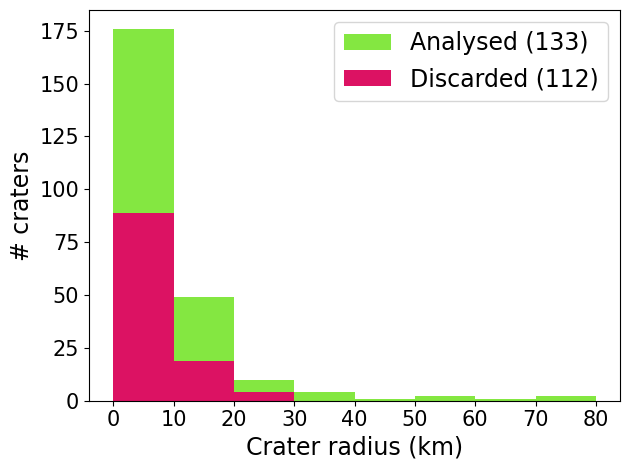

In [6]:
analysis = analysis_overlaps.loc[~analysis_overlaps['invalid'].values,:]
analysis_invalid = analysis_overlaps.loc[analysis_overlaps['invalid'].values,:]

plt.figure()
plt.hist(analysis['radius'], np.linspace(0,80,9), label='Analysed ('+str(len(analysis)-len(analysis_invalid))+')', color='#84e741')
plt.hist(analysis_invalid['radius'], np.linspace(0,80,9), label='Discarded ('+str(len(analysis_invalid))+')', color='#dc1263')
plt.xlabel('Crater radius (km)', fontsize=17)
plt.ylabel('# craters', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=17)
plt.tight_layout()
plt.show()

#
#
MANUAL MAPS ANALYSIS

Authors: Maria Kefa and Michele Lissoni

In [13]:
import glob
import os
import rioxarray
import numpy as np 
import pandas as pd
import sklearn.metrics as skm
import geopandas as gpd
from planet_constants import Planet_Basemap
from az_processing import getAzCRS, fillAz, reprojectAz, emptyAz
from rasterio.features import geometry_mask

from pos_processing import emptyPosMask
from planet_constants import Planet_Basemap

import matplotlib.pyplot as plt


hm_dir = "__EJMAP_ROOT_DIR__/data/man_data/"
ejc_data_root = '__EJMAP_ROOT_DIR__/data/ejc_data/'
cyl_data_root = "__EJMAP_ROOT_DIR__/data/cyl_data/"
dl_dir = os.path.join(cyl_data_root, "output_masks/ejc-version-200_conn-version-32_test-set-61_x20/")

# MAN craters
name_FID_dict = {'Amaral': 10,
                 'Basho': 8,
                 'Debussy': 12,
                 'Degas': 13,
                 'Enwonwu': 22,
                 'HanKan': 3,
                 'Hokusai': 0,
                 'Kuiper': 17,
                 'Waters': 71,
                 'XiaoZhao': 34}
crater_names = list(name_FID_dict.keys())

fresh_craters_gdf = gpd.read_file(os.path.join(ejc_data_root, 'fresh_craters.shp')).set_index('crat_FID')


This function computes the mask for the crater area, to exclude it from the analysis

In [14]:
def computeCraterMask(crat_FID, fresh_craters_gdf, half_size):

    center_lon = fresh_craters_gdf.loc[crat_FID, 'center_lon']
    center_lat = fresh_craters_gdf.loc[crat_FID, 'center_lat']
    crater_radius = fresh_craters_gdf.loc[crat_FID, 'radius']
    crater_radius_px = crater_radius/Planet_Basemap.BASEMAP_RESOLUTION
    crater_geoseries = fresh_craters_gdf.geometry.loc[[crat_FID]]

    tiny_mask = emptyAz((center_lon, center_lat))
    half_size0 = int(tiny_mask.shape[1]/2)
    
    tiny_half_size = min(int(crater_radius_px*3), half_size0)
    tiny_mask = tiny_mask[:, half_size0-tiny_half_size : half_size0+tiny_half_size, half_size0-tiny_half_size : half_size0+tiny_half_size] 
    tiny_transform = tiny_mask.rio.transform(recalc=True)
    
    az_crs = getAzCRS(center_lon, center_lat)
    crater_geometry = crater_geoseries.to_crs(az_crs).geometry.iloc[0]
    crater_mask0 = geometry_mask([crater_geometry], 
                                                  (tiny_half_size*2, tiny_half_size*2), 
                                                  tiny_transform,
                                                  all_touched = False,
                                                  invert=False)
    crater_mask = np.ones((1,half_size*2, half_size*2), dtype=np.uint8)
    crater_mask[:,half_size-tiny_half_size : half_size+tiny_half_size,half_size-tiny_half_size : half_size+tiny_half_size] = crater_mask0

    return crater_mask
    

Compare entire crater pattern, between MAN and deep learning and between MAN and TVT manual maps

In [10]:
metrics_df = pd.DataFrame(columns=['F1','F1_tiles','Precision','Precision_tiles','Recall','Recall_tiles'], index=crater_names)

# Create a raster mask to filter out the areas outside the manually-mapped TVT tiles, for the MAN-TVT comparison

human_positions = pd.read_csv(os.path.join(ejc_data_root, 'human_positions.csv'), index_col='pos_index')

cyl_tiles, _ = emptyPosMask()

for index, row in human_positions.iterrows():

    x = row.loc['x']
    y = row.loc['y']
    height = row.loc['height']
    width = row.loc['width']

    cyl_tiles[0,y:y+height, x:x+width] = 1

# Loop over MAN craters

for crater_name in crater_names:

    crat_FID = name_FID_dict[crater_name]

    center_lon = fresh_craters_gdf.loc[crat_FID, 'center_lon']
    center_lat = fresh_craters_gdf.loc[crat_FID, 'center_lat']

    crater_radius = fresh_craters_gdf.loc[crat_FID, 'radius']
    crater_radius_px = crater_radius/Planet_Basemap.BASEMAP_RESOLUTION
    crater_geoseries = fresh_craters_gdf.geometry.loc[[crat_FID]]

    dl_path = os.path.join(dl_dir, 'azimuthal_mask_crater_'+str(crat_FID)+'.tif') # Deep learning azimuthal mask
    hm_path = os.path.join(hm_dir, 'az_manual_'+crater_name+'.tif') # MAN azimuthal mask
    pos_path = os.path.join(cyl_data_root, 'mask_crater_'+str(crat_FID)+'.tif') # TVT cylindrical manual mask

    # Raster Loading
    dl = rioxarray.open_rasterio(dl_path).astype(np.uint8) 
    hm = rioxarray.open_rasterio(hm_path).astype(np.uint8)

    dl = fillAz(dl, (center_lon, center_lat))
    
    half_size = int(dl.shape[1]/2)

    # Exclude crater area
    crater_mask = computeCraterMask(crat_FID, fresh_craters_gdf, half_size)    
    dl[:,:,:] = dl.values*crater_mask
    hm[:,:,:] = hm.values*crater_mask

    # Reproject TVT cylindrical mask to azimuthal
    pos = rioxarray.open_rasterio(pos_path).astype(np.uint8)
    pos = reprojectAz(pos, (center_lon, center_lat), az_resolution = Planet_Basemap.BASEMAP_RESOLUTION, num_threads=12)

    az_tiles = reprojectAz(cyl_tiles, (center_lon, center_lat), az_resolution = Planet_Basemap.BASEMAP_RESOLUTION, num_threads=12)

    az_tiles[:,:,:] = az_tiles.values*crater_mask
    
    if dl.shape != hm.shape:
        print(crater_name, dl.shape, hm.shape)
        raise RuntimeError("The shapes are different!")
    
    # Squeeze to 2D
    dl_s = np.squeeze(dl.values)
    hm_s = np.squeeze(hm.values)

    pos_s = np.squeeze(pos.values)
    az_tiles_s = np.squeeze(az_tiles.values)

    pos_tiles = pos_s[np.nonzero(az_tiles_s)]
    hm_tiles = hm_s[np.nonzero(az_tiles_s)]

    # Compute metrics for MAN vs DL manually
    tp = np.sum((dl_s == 1) & (hm_s == 1))
    tn = np.sum((dl_s == 0) & (hm_s == 0))
    fp = np.sum((dl_s == 1) & (hm_s == 0))
    fn = np.sum((dl_s == 0) & (hm_s == 1))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    # MAN vs TVT
    precision_tiles = skm.precision_score(hm_tiles, pos_tiles)
    recall_tiles = skm.recall_score(hm_tiles, pos_tiles)
    f1_tiles = skm.f1_score(hm_tiles, pos_tiles)

    metrics_df.loc[crater_name,'F1']=f1
    metrics_df.loc[crater_name,'F1_tiles']=f1_tiles
    metrics_df.loc[crater_name,'Precision']=precision
    metrics_df.loc[crater_name,'Precision_tiles']=precision_tiles
    metrics_df.loc[crater_name,'Recall']=recall
    metrics_df.loc[crater_name,'Recall_tiles']=recall_tiles

    
    print(crater_name)
    print(f"Precision: {precision}, {precision_tiles}")
    print(f"Recall: {recall}, {recall_tiles}")
    print(f"F1 Score: {f1}, {f1_tiles}")
    print("--------")




KeyboardInterrupt: 

Analysis of 4 quadrants (Upper-left, upper-right, lower-right, lower-left)

In [5]:

BLOCK_SIZE = 1000  # pixels per block


precision_dict = {}
recall_dict = {}
f1_dict = {}

for crater_name in crater_names:

    crat_FID = name_FID_dict[crater_name]

    center_lon = fresh_craters_gdf.loc[crat_FID, 'center_lon']
    center_lat = fresh_craters_gdf.loc[crat_FID, 'center_lat']

    dl_path = os.path.join(dl_dir, 'azimuthal_mask_crater_'+str(crat_FID)+'.tif')
    hm_path = os.path.join(hm_dir, 'az_manual_'+crater_name+'.tif')
    
    n_rows = n_cols = None  

    
    dl_raster = rioxarray.open_rasterio(dl_path).astype(np.uint8)
    hm_raster = rioxarray.open_rasterio(hm_path).astype(np.uint8)
    dl_raster = fillAz(dl_raster, (center_lon, center_lat))

    n_rows, n_cols = dl_raster.sizes['y'], dl_raster.sizes['x']
    assert n_rows == n_cols

    #Exclude crater area
    crater_mask = computeCraterMask(crat_FID, fresh_craters_gdf, int(n_rows/2))

    dl_raster[:,:,:] = dl_raster.values*crater_mask
    hm_raster[:,:,:] = hm_raster.values*crater_mask
    

    
    # Quadrants
    squares = [
        (slice(0, n_rows//2), slice(0, n_cols//2)),
        (slice(0, n_rows//2), slice(n_cols//2, n_cols)),
        (slice(n_rows//2, n_rows), slice(0, n_cols//2)),
        (slice(n_rows//2, n_rows), slice(n_cols//2, n_cols))
    ]

    # Temporary lists to store metrics for this raster
    precision_list = []
    recall_list = []
    f1_list = []

    for i, (rows_slice, cols_slice) in enumerate(squares):
        tp = fp = tn = fn = 0

        for row_start in range(rows_slice.start, rows_slice.stop, BLOCK_SIZE):
            row_end = min(row_start + BLOCK_SIZE, rows_slice.stop)
            for col_start in range(cols_slice.start, cols_slice.stop, BLOCK_SIZE):
                col_end = min(col_start + BLOCK_SIZE, cols_slice.stop)
        
                dl_block = dl_raster.isel(y=slice(row_start, row_end), x=slice(col_start, col_end)).squeeze().data
                hm_block = hm_raster.isel(y=slice(row_start, row_end), x=slice(col_start, col_end)).squeeze().data
        
                dl_flat = dl_block.flatten().astype(np.uint8)
                hm_flat = hm_block.flatten().astype(np.uint8)
        
                tp += np.sum((hm_flat == 1) & (dl_flat == 1))
                fp += np.sum((hm_flat == 0) & (dl_flat == 1))
                tn += np.sum((hm_flat == 0) & (dl_flat == 0))
                fn += np.sum((hm_flat == 1) & (dl_flat == 0))

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    # Add results to the dicts
    precision_dict[crater_name] = precision_list
    recall_dict[crater_name] = recall_list
    f1_dict[crater_name] = f1_list

squares_names = [f"Square {i+1}" for i in range(4)]

df_precision_sq = pd.DataFrame(precision_dict, index=squares_names)
df_recall_sq = pd.DataFrame(recall_dict, index=squares_names)
df_f1_sq = pd.DataFrame(f1_dict, index=squares_names)


#df_precision.to_csv("precision_table.csv")
#df_recall.to_csv("recall_table.csv")
#df_f1.to_csv("f1_table.csv")

print("Precision table:")
print(df_precision_sq)
print(df_precision_sq.mean(axis=1))
print("\nRecall table:")
print(df_recall_sq)
print(df_recall_sq.mean(axis=1))
print("\nF1 table:")
print(df_f1_sq)
print(df_f1_sq.mean(axis=1))


Precision table:
            Amaral     Basho   Debussy     Degas   Enwonwu    HanKan  \
Square 1  0.417723  0.510657  0.685494  0.561538  0.574388  0.613799   
Square 2  0.101862  0.657818  0.648368  0.488170  0.695652  0.708480   
Square 3  0.545528  0.492895  0.569322  0.463821  0.494027  0.786108   
Square 4  0.557176  0.692881  0.702175  0.485078  0.656756  0.719465   

           Hokusai    Kuiper    Waters  XiaoZhao  
Square 1  0.289138  0.598167  0.638653  0.684409  
Square 2  0.352313  0.559358  0.314291  0.470900  
Square 3  0.449692  0.658787  0.688623  0.474009  
Square 4  0.426241  0.734210  0.557677  0.558040  
Square 1    0.557397
Square 2    0.499721
Square 3    0.562281
Square 4    0.608970
dtype: float64

Recall table:
            Amaral     Basho   Debussy     Degas   Enwonwu    HanKan  \
Square 1  0.363960  0.692000  0.435835  0.876873  0.579201  0.597113   
Square 2  0.737289  0.859305  0.684401  0.640039  0.494849  0.468760   
Square 3  0.299049  0.626514  0.62458

In [10]:
'''
metrics_df.to_csv(os.path.join(hm_dir,'dl_hm_metrics.csv'), index=True, index_label='Name')
df_precision_sq.to_csv(os.path.join(hm_dir,'dl_hm_precision_sq.csv'), index=True, index_label='Name')
df_recall_sq.to_csv(os.path.join(hm_dir,'dl_hm_recall_sq.csv'), index=True, index_label='Name')
df_f1_sq.to_csv(os.path.join(hm_dir,'dl_hm_f1_sq.csv'), index=True, index_label='Name')
'''

Circular Analysis, per decile of the MAN ejecta area (from the crater center outwards)

In [15]:
from pos_processing import denoiseMask
import matplotlib.pyplot as plt

# This function computes the blanket radius of the MAN masks
def computeBlanket(az_mask,
                   crater_radius, 
                   feat_min_size = 100, 
                   blanket_step = 4, 
                   blanket_start = 4, 
                   blanket_thres = 0.5, 
                   az_resolution = Planet_Basemap.BASEMAP_RESOLUTION):

    crater_radius_px = crater_radius/az_resolution
    
    half_size = int(az_mask.shape[1]/2)

    one_indices_x = np.flatnonzero(np.any(az_mask[0,:,:], axis=0))
    one_indices_y = np.flatnonzero(np.any(az_mask[0,:,:], axis=1))
    bound_min_x = np.amin(one_indices_x)
    bound_max_x = np.amax(one_indices_x)+1
    bound_min_y = np.amin(one_indices_y)
    bound_max_y = np.amax(one_indices_y)+1 

    half_size_new = np.amax(np.abs(np.array([bound_min_x, bound_max_x, bound_min_y, bound_max_y])-half_size))
        
    az_mask = az_mask[:,half_size-half_size_new:half_size+half_size_new, half_size-half_size_new:half_size+half_size_new].copy()
    az_mask = az_mask.values[0,:,:]
    
    xgrid, ygrid = np.meshgrid(np.arange(-half_size_new, half_size_new) + 0.5, np.flip(np.arange(-half_size_new, half_size_new)+ 0.5))
    all_distances = np.sqrt(np.square(xgrid)+np.square(ygrid))

    half_size = half_size_new
    
    az_mask = denoiseMask(az_mask, feat_min_size = feat_min_size)

    nonzero_indices_y, nonzero_indices_x = np.nonzero(az_mask)
    nonzero_coords_x = nonzero_indices_x - half_size + 0.5
    nonzero_coords_y = half_size - nonzero_indices_y - 0.5
    
    distances = np.sqrt(np.square(nonzero_coords_x) + np.square(nonzero_coords_y))
    
    perim_ratio = 1
    blanket_radius = int(blanket_start*crater_radius_px) - blanket_step
    
    while(perim_ratio > blanket_thres and blanket_radius < half_size):
        blanket_radius += blanket_step
        perim_points = np.sum((all_distances >= blanket_radius - blanket_step/2) & (all_distances < blanket_radius + blanket_step/2))
        perim_ejecta = np.sum((distances >= blanket_radius - blanket_step/2) & (distances < blanket_radius + blanket_step/2))
        perim_ratio = perim_ejecta*1.0/perim_points if perim_points > 0 else 0
        
    if(blanket_radius==int(blanket_start*crater_radius_px)):
        while(perim_ratio <= blanket_thres and blanket_radius>blanket_step):
            blanket_radius -= blanket_step
            perim_points = np.sum((all_distances >= blanket_radius - blanket_step/2) & (all_distances < blanket_radius + blanket_step/2))
            perim_ejecta = np.sum((distances >= blanket_radius - blanket_step/2) & (distances < blanket_radius + blanket_step/2))
            perim_ratio = perim_ejecta*1.0/perim_points if perim_points>0 else 0 

        blanket_radius = 0 if blanket_radius <= blanket_step or perim_points==0 else blanket_radius

    return blanket_radius

BLOCK = 1000  # block size

precision_dict = {}
recall_dict = {}
f1_dict = {}

# Pattern analyses
analysis = pd.read_csv(os.path.join(dl_dir, 'analysis_overlaps.csv'), index_col='crat_FID')
analysis_hm = pd.read_csv(os.path.join(hm_dir, 'analysis_hm.csv'), index_col='crat_FID')

blankets = pd.DataFrame(index=crater_names, columns=['dl_radius','hm_radius','dl_quantile','hm_quantile'])

for crater_name in crater_names:

    crat_FID = name_FID_dict[crater_name]

    center_lon = fresh_craters_gdf.loc[crat_FID, 'center_lon']
    center_lat = fresh_craters_gdf.loc[crat_FID, 'center_lat']
    radius = fresh_craters_gdf.loc[crat_FID, 'radius']

    dl_path = os.path.join(dl_dir, 'azimuthal_mask_crater_'+str(crat_FID)+'.tif')
    hm_path = os.path.join(hm_dir, 'az_manual_'+crater_name+'.tif')
    
    n_rows = n_cols = None  

    # Open ejecta masks
    dl_raster = rioxarray.open_rasterio(dl_path).astype(np.uint8)
    hm_raster = rioxarray.open_rasterio(hm_path).astype(np.uint8)
    dl_raster = fillAz(dl_raster, (center_lon, center_lat))

    n_rows, n_cols = dl_raster.sizes['y'], dl_raster.sizes['x']
    assert n_rows == n_cols
    half_size = int(n_rows/2)

    # Retrieve the blanket radius for the HM masks (easier than recomputing it)
    blanket_hm = analysis_hm.loc[crat_FID,'blanket_radius']#computeBlanket(hm_raster, radius)

    # Filter out the crater area
    crater_mask = computeCraterMask(crat_FID, fresh_craters_gdf, half_size)

    dl_raster[:,:,:] = dl_raster.values*crater_mask
    hm_raster[:,:,:] = hm_raster.values*crater_mask

    dl_s = np.squeeze(dl_raster.values)
    hm_s = np.squeeze(hm_raster.values)

    nrows, ncols = hm_s.shape

    center = np.array([half_size, half_size])
    wr, wc = np.where(hm_s == 1)
    dist_white = np.sqrt((wr - center[0])**2 + (wc - center[1])**2) # Distances of all ejecta pixels from crater center
    radius_99 = np.quantile(dist_white, 0.99)
    radius_95 = np.quantile(dist_white, 0.95)
    radius_90 = np.quantile(dist_white, 0.9)
    max_radius = dist_white.max()

    blanket_radius = analysis.loc[crat_FID, 'blanket_radius']

    blanket_quantile = np.sum(dist_white<blanket_radius)/len(dist_white)
    blanket_hm_quantile = np.sum(dist_white<blanket_hm)/len(dist_white)

    blankets.loc[crater_name, 'dl_quantile'] = blanket_quantile
    blankets.loc[crater_name, 'hm_quantile'] = blanket_hm_quantile
    
    print(crater_name, max_radius, radius_99, radius_95, radius_90, blanket_quantile, blanket_hm_quantile)

    # Distances from the center: the two blanket radii and the deciles of the distance
    circles = np.array([blanket_hm, blanket_radius])
    circles = np.append(circles, np.quantile(dist_white, np.arange(0.1,1.01,0.1)))
    
    precision_list = []
    recall_list = []
    f1_list = []

    #Compute metrics by circles (cumulative, the following one includes also the previous one)
    for i in range(0,len(circles)):

        r = circles[i]
        r_previous = 0 if i <= 2 else circles[i-1]
        
        y_test_all = []
        y_pred_all = []

        for row_start in range(0, nrows, BLOCK):
            row_end = min(row_start + BLOCK, nrows)
            for col_start in range(0, ncols, BLOCK):
                col_end = min(col_start + BLOCK, ncols)

                dl_block = dl_s[row_start:row_end, col_start:col_end]
                hm_block = hm_s[row_start:row_end, col_start:col_end]

                # Compute block coordinate grid
                br = np.arange(row_start, row_end)
                bc = np.arange(col_start, col_end)
                rows_b, cols_b = np.meshgrid(br, bc, indexing='ij')

                # Compute distances ONLY for this block
                dist_block = np.sqrt((rows_b - center[0])**2 +
                                     (cols_b - center[1])**2)

                # Mask of pixels inside ring
                # Uncomment second part to compute metrics only in annulus
                mask = (dist_block <= r) #& (dist_block >= r_previous)

                if np.any(mask):
                    y_test_all.append(hm_block[mask].astype(np.uint8))
                    y_pred_all.append(dl_block[mask].astype(np.uint8))

        
        y_test = np.concatenate(y_test_all)
        y_pred = np.concatenate(y_pred_all)

        # metrics
        precision_list.append(skm.precision_score(y_test, y_pred, zero_division=np.nan))
        recall_list.append(skm.recall_score(y_test, y_pred, zero_division=np.nan))
        f1_list.append(skm.f1_score(y_test, y_pred, zero_division=np.nan))

    # Store results
    precision_dict[crater_name] = precision_list
    recall_dict[crater_name] = recall_list
    f1_dict[crater_name] = f1_list


ring_names = ['Blanket_HM','Blanket_DL'] + [f"{i-1}" for i in range(2,len(circles))]

df_precision_ring = pd.DataFrame(precision_dict, index=ring_names)
df_recall_ring = pd.DataFrame(recall_dict, index=ring_names)
df_f1_ring = pd.DataFrame(f1_dict, index=ring_names)

# Uncomment to save
'''
blankets.to_csv(os.path.join(hm_dir,'blankets.csv'), index=True, index_label='Name')
df_precision_ring.to_csv(os.path.join(hm_dir,'dl_hm_precision_ring.csv'), index=True, index_label='Ring')
df_recall_ring.to_csv(os.path.join(hm_dir,'dl_hm_recall_ring.csv'), index=True, index_label='Ring')
df_f1_ring.to_csv(os.path.join(hm_dir,'dl_hm_f1_ring.csv'), index=True, index_label='Ring')
'''

print("Precision table:\n", df_precision_ring)
print("\nRecall table:\n", df_recall_ring)
print("\nF1 table:\n", df_f1_ring)

Amaral 2291.105628293903 2072.452855894225 1667.8048446882167 1316.4234119958564 0.37952730897595177 0.2407572237442435
Basho 2353.721521335946 2050.3832812152327 1650.2802792253199 1386.6225153227535 0.3769519008709289 0.26348169493616674
Debussy 3356.2294319667717 2881.1806781236833 2197.7596433639924 1911.9126287566846 0.2663629490316703 0.2634663551002606
Degas 3488.4737350308374 3086.85254587849 2531.2580665368246 1894.8472229691945 0.3508771929824561 0.2209670517757809
Enwonwu 2212.02938497661 1883.7904474530822 1203.9028199674117 875.7302666578271 0.2681806929234106 0.18320385717148616
HanKan 3763.066967248922 2511.0603437520585 2017.000247892895 1767.115163196785 0.13685221662897304 0.14114601340899552
Hokusai 8494.394033714236 7901.719286332539 7273.991641457827 6877.579937739715 0.0360820435720441 0.0
Kuiper 2978.8462531658124 2573.94861045496 2167.161680631548 1948.073150555344 0.2316445575764977 0.22773475961134815
Waters 1304.1786687413653 1152.0587745406433 959.7858615326

Plots

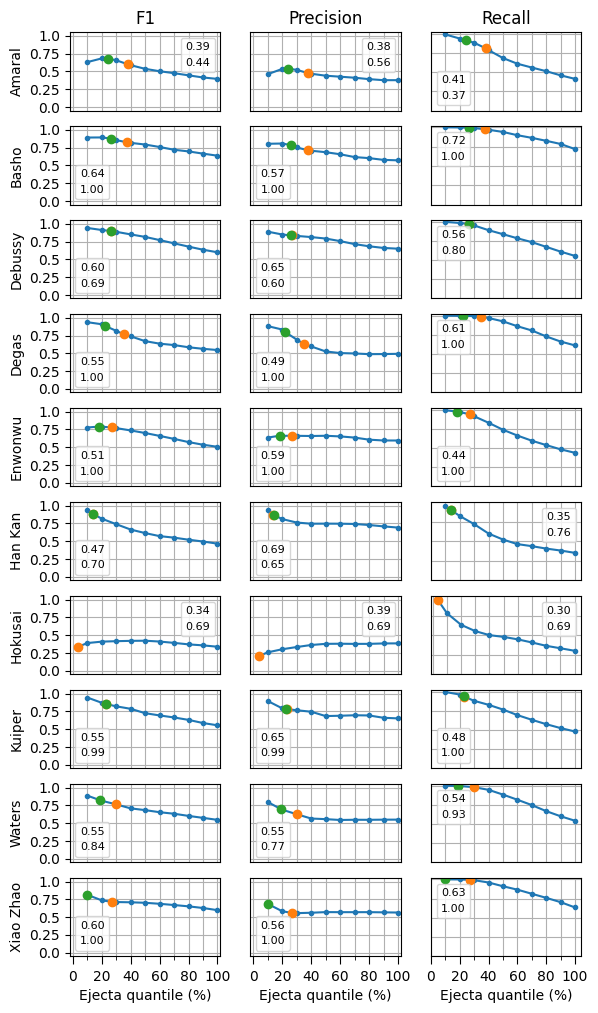

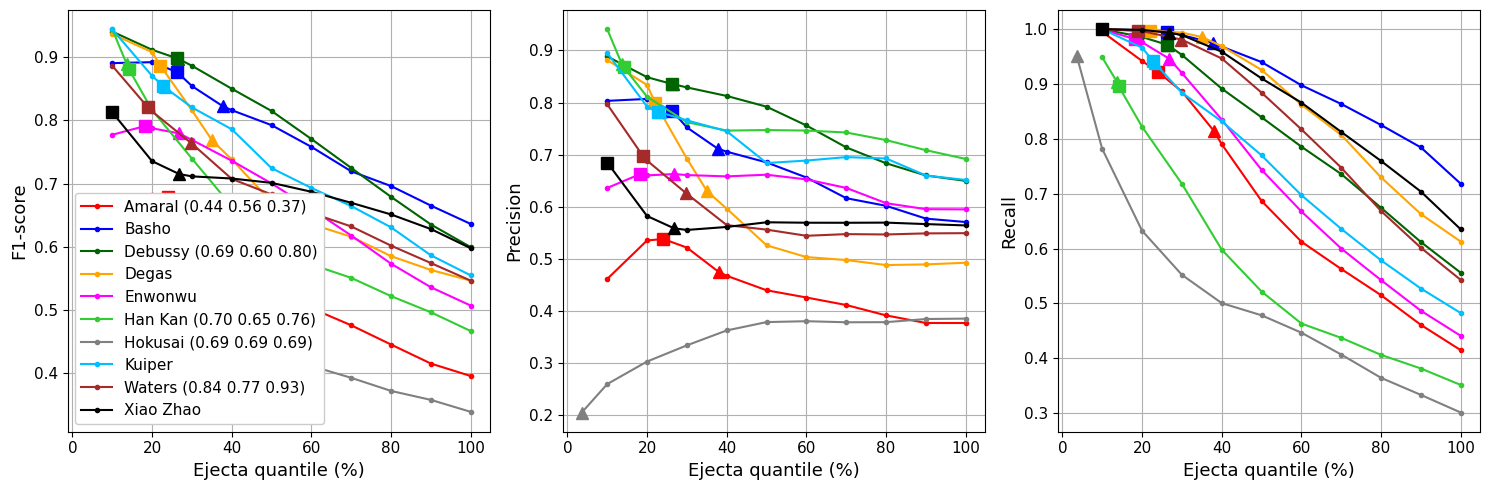

In [32]:
df_precision_ring = pd.read_csv(os.path.join(hm_dir,'dl_hm_precision_ring.csv'), index_col='Ring')
df_recall_ring = pd.read_csv(os.path.join(hm_dir,'dl_hm_recall_ring.csv'), index_col='Ring')
df_f1_ring = pd.read_csv(os.path.join(hm_dir,'dl_hm_f1_ring.csv'), index_col='Ring')
blankets = pd.read_csv(os.path.join(hm_dir,'blankets.csv'), index_col='Name')

metrics_df = pd.read_csv(os.path.join(hm_dir,'dl_hm_metrics.csv'), index_col='Name')

fig, ax = plt.subplots(10,3,figsize=(6.6,12)) # Individual plots

fig1, ax1 = plt.subplots(1,3, figsize = (15,5)) # Plots of all craters

quantiles0 = np.arange(10,101,10, dtype=int)

crater_labels = {'HanKan': 'Han Kan',
                'XiaoZhao': 'Xiao Zhao'}

colorlist = ['red','blue','darkgreen','orange','magenta','limegreen','grey','deepskyblue','brown','black']
#np.loadtxt('colorlist.txt', dtype=str)

for i,crater_name in enumerate(crater_names):

    # Sort the data points so that the blanket points will be in the right order
    blanket_quantiles = np.array([blankets.loc[crater_name,'dl_quantile'], blankets.loc[crater_name,'hm_quantile']])*100
    quantiles = np.append(quantiles0, blanket_quantiles)

    ring_indices = quantiles0/10
    ring_indices = np.append(ring_indices.astype(int).astype(str), ['Blanket_DL', 'Blanket_HM'])
    ring_indices = ring_indices[np.argsort(quantiles)]
    quantiles = np.sort(quantiles)

    f1 = df_f1_ring.loc[ring_indices, crater_name].values
    precision = df_precision_ring.loc[ring_indices, crater_name].values
    recall = df_recall_ring.loc[ring_indices, crater_name].values

    f1_all = metrics_df.loc[crater_name, 'F1']
    f1_tiles = metrics_df.loc[crater_name, 'F1_tiles']
    precision_all = metrics_df.loc[crater_name, 'Precision']
    precision_tiles = metrics_df.loc[crater_name, 'Precision_tiles']
    recall_all = metrics_df.loc[crater_name, 'Recall']
    recall_tiles = metrics_df.loc[crater_name, 'Recall_tiles']

    crater_label = crater_labels[crater_name] if crater_name in crater_labels else crater_name

    # Add TVT vs HM metrics to the independently-mapped craters
    if crater_name in ['Hokusai', 'HanKan', 'Amaral', 'Debussy', 'Waters']:
        f1_label = '{:.2f}'.format(f1_tiles) if f1_tiles < 0.995 else '1'
        precision_label = '{:.2f}'.format(precision_tiles) if precision_tiles < 0.995 else '1'
        recall_label = '{:.2f}'.format(recall_tiles) if recall_tiles < 0.995 else '1'
    
        crater_label = crater_label + f" ({f1_label} {precision_label} {recall_label})"

    # Single plot
    ax[i,0].plot(quantiles, f1, '.-')
    ax[i,1].plot(quantiles, precision, '.-')
    ax[i,2].plot(quantiles, recall, '.-')

    # Plot on multi-plot graph
    ax1[0].plot(quantiles, f1, '.-', label=crater_label, color=colorlist[i])
    ax1[1].plot(quantiles, precision, '.-', label=crater_label, color=colorlist[i])
    ax1[2].plot(quantiles, recall, '.-', label=crater_label, color=colorlist[i])

    # Plot blanket points in single plots
    ax[i,0].plot([blankets.loc[crater_name,'dl_quantile']*100], [df_f1_ring.loc['Blanket_DL', crater_name]], 'o', label="{:.2f}".format(f1_all))
    ax[i,1].plot([blankets.loc[crater_name,'dl_quantile']*100], [df_precision_ring.loc['Blanket_DL', crater_name]], 'o', label="{:.2f}".format(precision_all))
    ax[i,2].plot([blankets.loc[crater_name,'dl_quantile']*100], [df_recall_ring.loc['Blanket_DL', crater_name]], 'o', label="{:.2f}".format(recall_all))

    ax[i,0].plot([blankets.loc[crater_name,'hm_quantile']*100], [df_f1_ring.loc['Blanket_HM', crater_name]], 'o', label="{:.2f}".format(f1_tiles))
    ax[i,1].plot([blankets.loc[crater_name,'hm_quantile']*100], [df_precision_ring.loc['Blanket_HM', crater_name]], 'o', label="{:.2f}".format(precision_tiles))
    ax[i,2].plot([blankets.loc[crater_name,'hm_quantile']*100], [df_recall_ring.loc['Blanket_HM', crater_name]], 'o', label="{:.2f}".format(recall_tiles))

    # Plot blanket points in multi-plot
    ax1[0].plot([blankets.loc[crater_name,'dl_quantile']*100], [df_f1_ring.loc['Blanket_DL', crater_name]], '^', color=colorlist[i], ms=8)
    ax1[1].plot([blankets.loc[crater_name,'dl_quantile']*100], [df_precision_ring.loc['Blanket_DL', crater_name]], '^', color=colorlist[i], ms=8)
    ax1[2].plot([blankets.loc[crater_name,'dl_quantile']*100], [df_recall_ring.loc['Blanket_DL', crater_name]], '^', color=colorlist[i], ms=8)

    ax1[0].plot([blankets.loc[crater_name,'hm_quantile']*100], [df_f1_ring.loc['Blanket_HM', crater_name]], 's', color=colorlist[i], ms=8)
    ax1[1].plot([blankets.loc[crater_name,'hm_quantile']*100], [df_precision_ring.loc['Blanket_HM', crater_name]], 's', color=colorlist[i], ms=8)
    ax1[2].plot([blankets.loc[crater_name,'hm_quantile']*100], [df_recall_ring.loc['Blanket_HM', crater_name]], 's', color=colorlist[i], ms=8)

    
    labels = ["{:.2f}".format(f1_all),"{:.2f}".format(f1_tiles)] # Add DL vs HM and TVT vs HM metrics to single-plot legends
    handles = [plt.Line2D([], [], linestyle='none') for _ in labels]
    
    ax[i,0].legend(
        handles,
        labels,
        frameon=True,
        handlelength=0,
        handletextpad=0,
        fontsize=8
    )

    labels = ["{:.2f}".format(precision_all),"{:.2f}".format(precision_tiles)]
    handles = [plt.Line2D([], [], linestyle='none') for _ in labels]
    
    ax[i,1].legend(
        handles,
        labels,
        frameon=True,
        handlelength=0,
        handletextpad=0,
        fontsize = 8,
    )

    labels = ["{:.2f}".format(recall_all),"{:.2f}".format(recall_tiles)]
    handles = [plt.Line2D([], [], linestyle='none') for _ in labels]
    
    ax[i,2].legend(
        handles,
        labels,
        frameon=True,
        handlelength=0,
        handletextpad=0,
        fontsize = 8
    )

    # Set labels at the exterior of the single plots
    ax[i,0].set_ylabel(crater_labels[crater_name] if crater_name in crater_labels else crater_name)

    ax[i,0].set_xlim(-2,102)
    ax[i,1].set_xlim(-2,102)
    ax[i,1].set_xlim(-2,102)

    ax[i,0].set_ylim(-0.05,1.05)
    ax[i,1].set_ylim(-0.05,1.05)
    ax[i,1].set_ylim(-0.05,1.05)
    
    ax[i,0].set_xticks(np.arange(0,101,20))
    ax[i,0].set_yticks(np.linspace(0,1,5))
    ax[i,1].set_xticks(np.arange(0,101,20))
    ax[i,1].set_yticks(np.linspace(0,1,5))
    ax[i,2].set_xticks(np.arange(0,101,20))
    ax[i,2].set_yticks(np.linspace(0,1,5))

    ax[i,0].set_xticks(np.arange(10,101,20), minor=True)
    ax[i,1].set_xticks(np.arange(10,101,20), minor=True)
    ax[i,2].set_xticks(np.arange(10,101,20), minor=True)
    
    ax[i,0].set_yticklabels(np.linspace(0,1,5))
    ax[i,1].set_yticklabels([])
    ax[i,1].tick_params(axis='y', length=0)
    ax[i,2].set_yticklabels([])
    ax[i,2].tick_params(axis='y', length=0)

    if i == 0:
        ax[i,0].set_title('F1')
        ax[i,1].set_title('Precision')
        ax[i,2].set_title('Recall')

    if i == len(crater_names) - 1:
        ax[i,0].set_xlabel('Ejecta quantile (%)')
        ax[i,1].set_xlabel('Ejecta quantile (%)')
        ax[i,2].set_xlabel('Ejecta quantile (%)')

        xticklabels = np.linspace(0,100,6, dtype=int)
        xticklength = 6

    else:

        xticklabels = []
        xticklength = 0

    ax[i,0].set_xticklabels(xticklabels)
    ax[i,0].tick_params(axis='x', length=xticklength, which='major')
    ax[i,1].set_xticklabels(xticklabels)
    ax[i,1].tick_params(axis='x', length=xticklength, which='major')
    ax[i,2].set_xticklabels(xticklabels)
    ax[i,2].tick_params(axis='x', length=xticklength, which='major')

    ax[i,0].tick_params(axis='x', length=xticklength/2, which='minor')
    ax[i,1].tick_params(axis='x', length=xticklength/2, which='minor')
    ax[i,2].tick_params(axis='x', length=xticklength/2, which='minor')

    ax[i,0].grid(which='both')
    ax[i,1].grid(which='both')
    ax[i,2].grid(which='both')

ax1[0].legend(ncol=1, framealpha=1, fontsize=11)
#ax1[1].legend(ncol=3)
#ax1[2].legend(ncol=3)
ax1[0].grid()
ax1[1].grid()
ax1[2].grid()

ax1[0].set_xlabel('Ejecta quantile (%)', fontsize=13)
ax1[1].set_xlabel('Ejecta quantile (%)', fontsize=13)
ax1[2].set_xlabel('Ejecta quantile (%)', fontsize=13)

ax1[0].set_ylabel('F1-score', fontsize=13)
ax1[1].set_ylabel('Precision', fontsize=13)
ax1[2].set_ylabel('Recall', fontsize=13)

ax1[0].tick_params(labelsize=11)
ax1[1].tick_params(labelsize=11)
ax1[2].tick_params(labelsize=11)

plt.tight_layout()
plt.show()
    

#
#
PATTERN PLOTS

Three plots: the DL map (if present), the HM mask, the masks of nearby craters

DL Blanket: 297363.68926137
HM Blanket: 222856.45615785


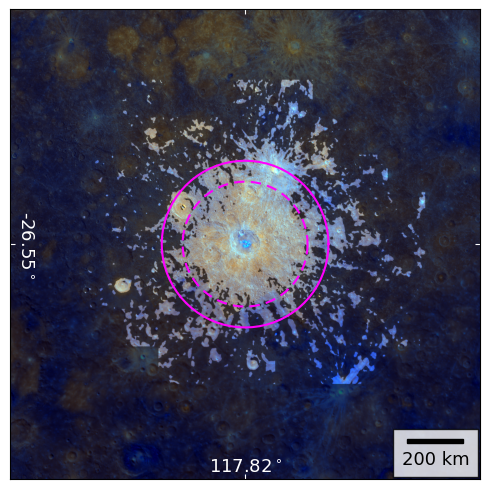

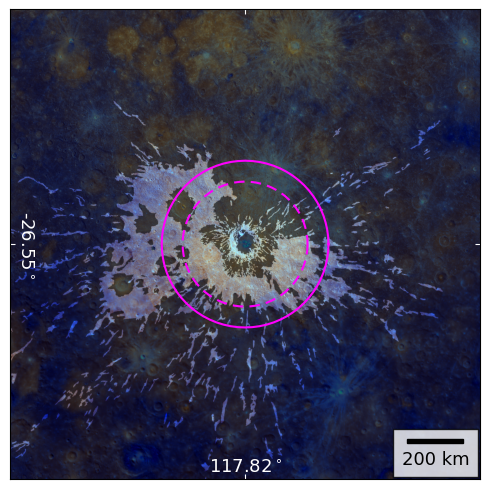

[ 50 229  65 230  57 228 227  22  69  74]


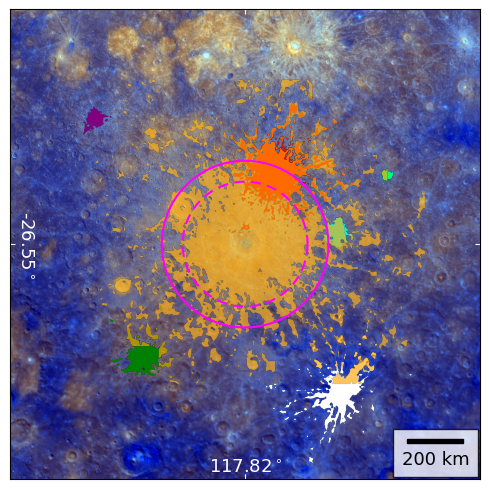

In [9]:
from az_processing import fillAz, reprojectAz, emptyAz, getAzCRS
from shapely import Point
from planet_constants import Planet_CRS, Planet_Basemap
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import rioxarray
import matplotlib.colors as clrs
import matplotlib.pyplot as plt
import gc
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import pyproj

crat_FID = 10 # Main crater
size_factor = 0.55 # Fraction of the total extent of the HM mask (if present, else DL) to show
center_traslation = [0,0] # Shift of center wrt to center of the image
shade_alpha = 0.6 # The ejecta pixels are transparent, the non-ejecta are black and semi-transparent, set here their alpha
other_alpha = [1,1,1,1,1,1,0.65] # Alpha of the other ejecta masks (third plot)
other_outside_alpha = 0 # In third plot, increasing this alpha allows you to darken the area not covered by any ejecta
plot_blanket = True # Plot blanket radii in first two plots
blanket_in_others = False # Plot blanket radii in third plot
blanket_thick = 1.5 # Thickness of blanket line
plot_others = True # Plot third plot
which_others = [227, 50, 57, 65, 229, 230, 10] # Craters to plot in third plot
other_colors = ['purple', 'red', 'white','green','cyan','springgreen','orange'] # Colors of craters to plot in third plot
other_ifoverlap = False # If `which_others` is None, set True to plot craters overlapping main crater's DL mask
overlap_thres = 0.05 # If `other_ifoverlap` is True, set overlap lower threshold
plot_others_and_main = False # If `which_others` is None, choose if main crater mask is also plotted
figsize=5 # Figsize

###########################

FID_name_dict = {10: 'Amaral',
                 8: 'Basho',
                 12: 'Debussy',
                 13: 'Degas',
                 22: 'Enwonwu',
                 3: 'HanKan',
                 0: 'Hokusai',
                 17: 'Kuiper',
                 71: 'Waters',
                 34: 'XiaoZhao'}

map_dir = "__EJMAP_ROOT_DIR__/results/output_masks/ejc-version-200_conn-version-32_test-set-61_x20"
hm_dir = "__EJMAP_ROOT_DIR__/data/man_data/"

ejc_data_root = '__EJMAP_ROOT_DIR__/data/ejc_data/'
fresh_craters_gdf = gpd.read_file(os.path.join(ejc_data_root, 'fresh_craters.shp')).set_index('crat_FID')

analysis = pd.read_csv(os.path.join(map_dir, 'analysis_overlaps.csv'), index_col='crat_FID')
analysis_hm = pd.read_csv(os.path.join(hm_dir, 'analysis_hm.csv'), index_col='crat_FID')

center_lon = fresh_craters_gdf.loc[crat_FID, 'center_lon']
center_lat = fresh_craters_gdf.loc[crat_FID, 'center_lat']
az_crs = getAzCRS(center_lon, center_lat)

latlon_crs = Planet_CRS.LATLON_CRS
transformer = pyproj.Transformer.from_crs(az_crs, latlon_crs, always_xy=True)

az_mosaic = rioxarray.open_rasterio(os.path.join(ejc_data_root, 'mosaics', 'azimuthal_mosaic_crater_'+str(crat_FID)+'.tif')).astype(np.uint8)
dl_mask = rioxarray.open_rasterio(os.path.join(map_dir, 'azimuthal_mask_crater_'+str(crat_FID)+'.tif')).astype(np.uint8)

max_half_size = int(az_mosaic.shape[1]/2)

half_size = int(dl_mask.shape[1]/2)

# Open HM mask if present and resize it
if crat_FID in list(FID_name_dict.keys()):
    hm_mask = rioxarray.open_rasterio(os.path.join(hm_dir, 'az_manual_'+FID_name_dict[crat_FID]+'.tif')).astype(np.uint8)

    one_indices_x = np.flatnonzero(np.any(hm_mask[0,:,:], axis=0))
    one_indices_y = np.flatnonzero(np.any(hm_mask[0,:,:], axis=1))
    bound_min_x = np.amin(one_indices_x)
    bound_max_x = np.amax(one_indices_x)+1
    bound_min_y = np.amin(one_indices_y)
    bound_max_y = np.amax(one_indices_y)+1 
    
    half_size_hm = np.amax(np.abs(np.array([bound_min_x, bound_max_x, bound_min_y, bound_max_y])-max_half_size))

    if half_size_hm > half_size:
        half_size = half_size_hm
else:
    hm_mask = emptyAz((center_lon, center_lat)).astype(np.uint8)

# Set center
center_traslation = np.array(center_traslation)*half_size
center_x = max_half_size + int(center_traslation[0])
center_y = max_half_size - int(center_traslation[1])
half_size = int(half_size*size_factor) # Set size of area shown in image

resolution = Planet_Basemap.BASEMAP_RESOLUTION

central_lon, central_lat = transformer.transform(int(center_traslation[0])*resolution, int(center_traslation[1])*resolution)

# Resize azimuthal mosaic
az_mosaic = az_mosaic[:,center_y-half_size:center_y+half_size, center_x-half_size:center_x+half_size]
x_left, y_down, x_right, y_up = az_mosaic.rio.bounds(recalc=True)
small_mosaic_tr = np.transpose(az_mosaic.values, (1,2,0))
del az_mosaic
gc.collect()

hm_mask = hm_mask[0,center_y-half_size:center_y+half_size, center_x-half_size:center_x+half_size].values
dl_mask = fillAz(dl_mask, (center_lon, center_lat))[0,center_y-half_size:center_y+half_size, center_x-half_size:center_x+half_size].values

cmap = clrs.ListedColormap([(0,0,0,shade_alpha), (0,0,0,0)])
norm = clrs.BoundaryNorm([0,0.5,1], cmap.N)

# Add scalebar function
def add_scalebar(ax, half_size, resolution = Planet_Basemap.BASEMAP_RESOLUTION):

    scales = np.tile([1,2,5], 7)*np.repeat([1,10,100,1000,10000,100000,1000000],3)
    scale = scales[np.argmin(np.abs(scales - half_size*2/7*resolution))]
    
    if scale < 1000:
        scale_label = str(int(scale))+' m'
    else:
        scale_label = str(int(scale/1000))+' km'
                     
    scalebar = AnchoredSizeBar(
        ax.transData,
        scale/resolution,  # size in data coordinates
        scale_label,
        loc='lower right',
        pad=0.5,
        color='black',
        frameon=True,  # Enable the frame/box
        size_vertical=half_size * 0.02,  # Height of the bar (end caps)
        fontproperties=fm.FontProperties(size=13),
        sep=5#,  # Separation between bar and label
        #bbox_to_anchor=(0.95, 0.05),
        #bbox_transform=ax.transAxes
    )
    
    # Customize the frame (white background)
    scalebar.patch.set_facecolor('white')
    scalebar.patch.set_edgecolor('black')
    scalebar.patch.set_linewidth(1)
    scalebar.patch.set_alpha(0.8)
    
    ax.add_artist(scalebar)
    return scalebar

blanket_radius = analysis.loc[crat_FID, 'blanket_radius']
hm_blanket_radius = analysis_hm.loc[crat_FID, 'blanket_radius'] if crat_FID in list(FID_name_dict.keys()) else 0

print('DL Blanket:', blanket_radius*resolution)
print('HM Blanket:', hm_blanket_radius*resolution)

# Blanket circles

circle_angles = np.arange(0,361,5)/180*np.pi
circle_coords = np.hstack([np.cos(circle_angles)[:,np.newaxis], np.sin(circle_angles)[:,np.newaxis]])*blanket_radius+half_size
circle_coords = circle_coords + center_traslation[np.newaxis,:]*np.array([[-1,1]])

if hm_blanket_radius == 0:
    hm_circle_coords = np.zeros((0,2))
else:
    hm_circle_coords = np.hstack([np.cos(circle_angles)[:,np.newaxis], np.sin(circle_angles)[:,np.newaxis]])*hm_blanket_radius+half_size
    hm_circle_coords = hm_circle_coords + center_traslation[np.newaxis,:]*np.array([[-1,1]])

# DL plot
    
fig, ax = plt.subplots(1,1,figsize=(figsize,figsize))
ax.imshow(small_mosaic_tr)
ax.imshow(dl_mask, cmap=cmap, norm=norm)
if plot_blanket:
    ax.plot(circle_coords[:,0], circle_coords[:,1], '-', color='fuchsia', linewidth = blanket_thick, zorder=2)
    ax.plot(hm_circle_coords[:,0], hm_circle_coords[:,1], '--', color='fuchsia', dashes=(5,3), linewidth = blanket_thick, zorder=2)

add_scalebar(ax, half_size, resolution=resolution)

# Set ticks to indicate the coordinates of the center of the plot
ax.set_xticks([half_size],[f"{central_lon:.2f}"r"$^\circ$"])
ax.set_yticks([half_size],[f"{central_lat:.2f}"r"$^\circ$"])
ax.tick_params(axis='x', direction='in', colors='white', pad = -15, top=True, right=True, labeltop=False, labelright=False, labelsize=13)
ax.tick_params(axis='y', direction='in', colors='white', pad = -11, labelrotation=270, top=True, right=True, labeltop=False, labelright=False, labelsize=13)
for label in ax.get_yticklabels():
    label.set_rotation(270)
    label.set_verticalalignment('center')  # Center on tick
    label.set_horizontalalignment('center')
        
plt.tight_layout()
plt.show()

# HM plot

if crat_FID in list(FID_name_dict.keys()):
    fig, ax = plt.subplots(1,1,figsize=(figsize,figsize))
    ax.imshow(small_mosaic_tr)
    ax.imshow(hm_mask, cmap=cmap, norm=norm)

    if plot_blanket:
        ax.plot(circle_coords[:,0], circle_coords[:,1], '-', color='fuchsia', linewidth = blanket_thick, zorder=2)
        ax.plot(hm_circle_coords[:,0], hm_circle_coords[:,1], '--', color='fuchsia', dashes=(5,3), linewidth = blanket_thick, zorder=2)
    
    add_scalebar(ax, half_size, resolution=resolution)
    
    ax.set_xticks([half_size],[f"{central_lon:.2f}"r"$^\circ$"])
    ax.set_yticks([half_size],[f"{central_lat:.2f}"r"$^\circ$"])
    ax.tick_params(axis='x', direction='in', colors='white', pad = -15, top=True, right=True, labeltop=False, labelright=False, labelsize=13)
    ax.tick_params(axis='y', direction='in', colors='white', pad = -11, labelrotation=270, top=True, right=True, labeltop=False, labelright=False, labelsize=13)
    for label in ax.get_yticklabels():
        label.set_rotation(270)
        label.set_verticalalignment('center')  # Center on tick
        label.set_horizontalalignment('center')
    
    plt.tight_layout()
    plt.show()
    
# If `which_others` is None, plot the other crater ejecta from closest to furthest
if which_others is None:
    fresh_centroids = gpd.GeoDataFrame(index = fresh_craters_gdf.index.values, geometry=[Point(fresh_craters_gdf.loc[crat_FID, 'center_lon'], 
                                                       fresh_craters_gdf.loc[crat_FID, 'center_lat']) for crat_FID in fresh_craters_gdf.index.values], 
                                       crs=Planet_CRS.LATLON_CRS)
    fresh_centroids = fresh_centroids.to_crs(az_crs)
    centroid_coords = np.array([[p.x, p.y] for p in fresh_centroids.geometry.values])
    centroid_indices = np.flatnonzero((centroid_coords[:,0] >= x_left) & 
                                                          (centroid_coords[:,0] <= x_right) &
                                                          (centroid_coords[:,1] >= y_down) & 
                                                          (centroid_coords[:,1] <= y_up))
    fresh_centroids = fresh_centroids.iloc[centroid_indices,:]
    centroid_coords = centroid_coords[centroid_indices,:]
    centroid_distances = np.sqrt(np.square(centroid_coords[:,0])+np.square(centroid_coords[:,1]))
    fresh_centroids = fresh_centroids.iloc[np.argsort(centroid_distances),:]
    fresh_centroids = fresh_centroids.drop(crat_FID, axis=0)
    centroid_distances = np.sort(centroid_distances)[1:]
    
    other_FIDs = fresh_centroids.index.values
    centroid_distances = centroid_distances[other_FIDs!=crat_FID]
    other_FIDs = other_FIDs[other_FIDs!=crat_FID]
    other_FIDs = other_FIDs[np.argsort(centroid_distances)]
    print(other_FIDs)

    other_colors = np.loadtxt('colorlist.txt', dtype=str) if other_colors is None else other_colors
else: # If `which_others` is not None, its order is followed
    other_FIDs = which_others

other_outside = emptyAz((center_lon, center_lat))[0,max_half_size-half_size:max_half_size+half_size, max_half_size-half_size:max_half_size+half_size].values

# Other craters plot

if plot_others:
    fig, ax = plt.subplots(1,1,figsize=(figsize,figsize))
    ax.imshow(small_mosaic_tr)

    if isinstance(other_alpha, float) or isinstance(other_alpha,int):
        other_alpha = np.repeat(other_alpha,len(other_FIDs))
    
    for i, other_FID in enumerate(other_FIDs):
    
        other_mask = rioxarray.open_rasterio(os.path.join(map_dir, 'cylindrical_mask_crater_'+str(other_FID)+'.tif')).astype(np.uint8)
        other_mask = reprojectAz(other_mask, (center_lon, center_lat), num_threads=12)[0,center_y-half_size:center_y+half_size, center_x-half_size:center_x+half_size].values

        other_outside = other_outside + other_mask
        
        overlap = np.sum(other_mask*dl_mask)/np.sum(dl_mask)
    
        if (other_ifoverlap and overlap > overlap_thres) or not other_ifoverlap:
        
            color_rgba = clrs.to_rgba(other_colors[i])
            color_rgba = (color_rgba[0], color_rgba[1], color_rgba[2], other_alpha[i])
        
            cmap_other = clrs.ListedColormap([(0,0,0,0), color_rgba])
            norm_other = clrs.BoundaryNorm([0,0.5,1], cmap_other.N)
            ax.imshow(other_mask, cmap=cmap_other, norm=norm_other)

    # Area not covered by ejecta
    other_outside = other_outside>0
    other_outside = other_outside.astype(np.uint8)
    cmap_outside = clrs.ListedColormap([(0,0,0,other_outside_alpha), (0,0,0,0)])
    norm_outside = clrs.BoundaryNorm([0,0.5,1], cmap_outside.N)
    ax.imshow(other_outside, cmap=cmap_outside, norm=norm_outside)    

    if plot_others_and_main:
        ax.imshow(dl_mask, cmap=cmap, norm=norm)

    # Plot blanket circles
    if blanket_in_others:
        ax.plot(circle_coords[:,0], circle_coords[:,1], '-', color='fuchsia', linewidth = blanket_thick, zorder=2)
        ax.plot(hm_circle_coords[:,0], hm_circle_coords[:,1], '--', color='fuchsia', dashes=(5,3), linewidth = blanket_thick, zorder=2)

    add_scalebar(ax, half_size, resolution=resolution)

    ax.set_xticks([half_size],[f"{central_lon:.2f}"r"$^\circ$"])
    ax.set_yticks([half_size],[f"{central_lat:.2f}"r"$^\circ$"])
    ax.tick_params(axis='x', direction='in', colors='white', pad = -15, top=True, right=True, labeltop=False, labelright=False, labelsize=13)
    ax.tick_params(axis='y', direction='in', colors='white', pad = -11, labelrotation=270, top=True, right=True, labeltop=False, labelright=False, labelsize=13)
    for label in ax.get_yticklabels():
        label.set_rotation(270)
        label.set_verticalalignment('center')  # Center on tick
        label.set_horizontalalignment('center')    

    plt.tight_layout()
    plt.show()